# Python for Creating CSV and Preliminary Reporting

In [1]:
import csv
import contextily as cx
import geopandas as gpd
import hvplot.pandas as hpd
import json
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import urllib


#import geopandas as gpd

%matplotlib inline
plt.style.use('ggplot')

from datetime import date
print("Last run: ", date.today())

#gv.extension('bokeh', 'matplotlib')

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


Last run:  2023-01-08


## Load Data and Write to CSV


In [30]:
with open("roman-amphitheaters.geojson") as f:
    j = json.load(f)

In [31]:
# If there is one, I'd welcome a more pythonic approach. One that 
# accomodates the variable data model supported by JSON.

d = []
for feature in j['features']:
    
    # Check for optional properties

    latintoponym = ''
    if 'latintoponym' in feature['properties'].keys():
        latintoponym = feature['properties']['latintoponym']
            
    welchid = ''
    if 'welchid' in feature['properties'].keys():
        welchid = feature['properties']['welchid']
        
    golvinid = ''
    if 'golvinid' in feature['properties'].keys():
        golvinid = feature['properties']['golvinid']

    buildingtype = ''
    if 'buildingtype' in feature['properties'].keys():
        buildingtype = feature['properties']['buildingtype']
            
    try:
        zotero = feature['properties']['bibliography'][0]['zoteroitem']
    except:
        zotero = ''
 
    chronogroup = ''
    if 'chronogroup' in feature['properties'].keys():
        chronogroup = feature['properties']['chronogroup']
        
    secondcentury = True
    if 'exclude' in feature['properties'].keys():
        secondcentury = False

    capacity = ''
    if 'capacity' in feature['properties'].keys():
        if 'quantity' in feature['properties']['capacity']:
            capacity = feature['properties']['capacity']['quantity']


    romanregion = ''
    if 'province' in feature['properties'].keys():
        romanregion = feature['properties']['province']
    elif 'region' in feature['properties'].keys():
        romanregion = feature['properties']['region']
        
        
    arenamajor = ''
    arenaminor = ''
    extmajor = ''
    extminor = ''
    exteriorheight = ''
    dimensionsunknown = True
    if 'dimensions' in feature['properties'].keys():
        dimensions = feature['properties']['dimensions']
        
        if 'arenamajor' in dimensions:
            if type(dimensions['arenamajor']) == int or type(dimensions['arenamajor']) == float:
                arenamajor = dimensions['arenamajor']
                dimensionsunknown = False

        if 'arenaminor' in dimensions:
            if type(dimensions['arenaminor']) == int or type(dimensions['arenaminor']) == float:
                arenaminor = dimensions['arenaminor']
                dimensionsunknown = False
            
        if 'exteriormajor' in dimensions:
            if type(dimensions['exteriormajor']) == int or type(dimensions['exteriormajor']) == float:
                extmajor = dimensions['exteriormajor']
                dimensionsunknown = False

        if 'exteriorminor' in dimensions:
            if type(dimensions['exteriorminor']) == int or type(dimensions['exteriorminor']) == float:
                extminor = dimensions['exteriorminor']
                dimensionsunknown = False
            
        if 'exteriorheight' in dimensions:
            if type(dimensions['exteriorheight']) == int or type(dimensions['exteriorheight']) == float:
                exteriorheight = dimensions['exteriorheight']
      
    d.append((feature['id'],
              feature['properties']['title'],
              feature['properties']['label'],
              latintoponym,
              feature['properties']['pleiades'],
              welchid,
              golvinid,
              buildingtype,
              chronogroup,
              secondcentury,
              capacity,
              feature['properties']['moderncountry'],
              romanregion,
              zotero,
              dimensionsunknown,
              arenamajor,
              arenaminor,
              extmajor,
              extminor,
              exteriorheight,
              feature['geometry']['coordinates'][0],
              feature['geometry']['coordinates'][1],
              feature['geometry']['coordinates'][2]))

ramphs_df = pd.DataFrame(d, columns=(
 'id',    # short id
 'title', # longer title
 'label', # short label
 'latintoponym', # latin toponym
 'pleiades', # pleiades https uri
 'welchid',  # id in Welch
 'golvinid', # id in Golvin
 'buildingtype',  # usually 'amphitheater'
 'chronogroup',   # label for the chronological group
 'secondcentury', # is this an amphitheater that was in use in 2nd century
 'capacity',    # capacity as integer
 'modcountry',  # modern country
 'romanregion', # province or augustan region of italy
 'zotero',      # zotero item id
 'dimensionsunknown', # if true, that's a direct statement that no dimensions are available
 'arenamajor', # long axis of arena in meters
 'arenaminor', # short axis of arena in meters
 'extmajor',   # long axis of exterior
 'extminor', # short axis of exterior
 'exteriorheight',   # height of exterior wall if known
 'longitude', # longitude
 'latitude', # latitude
 'elevation'  # elevation in meters.
 )) 

ramphs_df[['capacity','elevation','arenamajor','arenaminor',
        'extmajor','extminor','exteriorheight']] = ramphs_df[['capacity','elevation','arenamajor',
        'arenaminor','extmajor','extminor','exteriorheight']].apply(pd.to_numeric)

In [32]:
ramphs_df.to_csv("roman-amphitheaters.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

False


<AxesSubplot:>

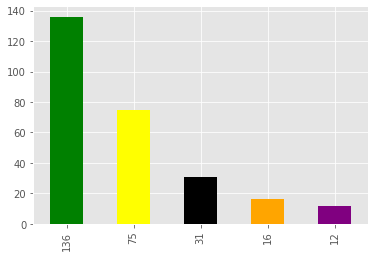

In [33]:
ramphs_df['displaycolor'] = 'red' # problem

ramphs_df.loc[ramphs_df[['capacity']].notnull().all(1),'displaycolor'] = 'purple' # any capacity
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor','capacity']].notnull().all(1),'displaycolor'] = 'green' # 4 dims, cap, complete

ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().any(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'yellow' # any dim, no cap
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().all(1) & ramphs_df['capacity'].isnull(),'displaycolor'] = 'orange' # 4 dims, no cap

ramphs_df.loc[ramphs_df['dimensionsunknown'] == True,'displaycolor'] = 'black' # no dims, might be a cap 'nazili'

# this should be False
print('red' in list(ramphs_df.displaycolor.unique()))

bar_series = ramphs_df['displaycolor'].value_counts()

bar_series.index = ramphs_df['displaycolor'].value_counts()


bar_series.plot.bar(color = ramphs_df['displaycolor'].value_counts().index, xlabel = '')


## Basic Mapping

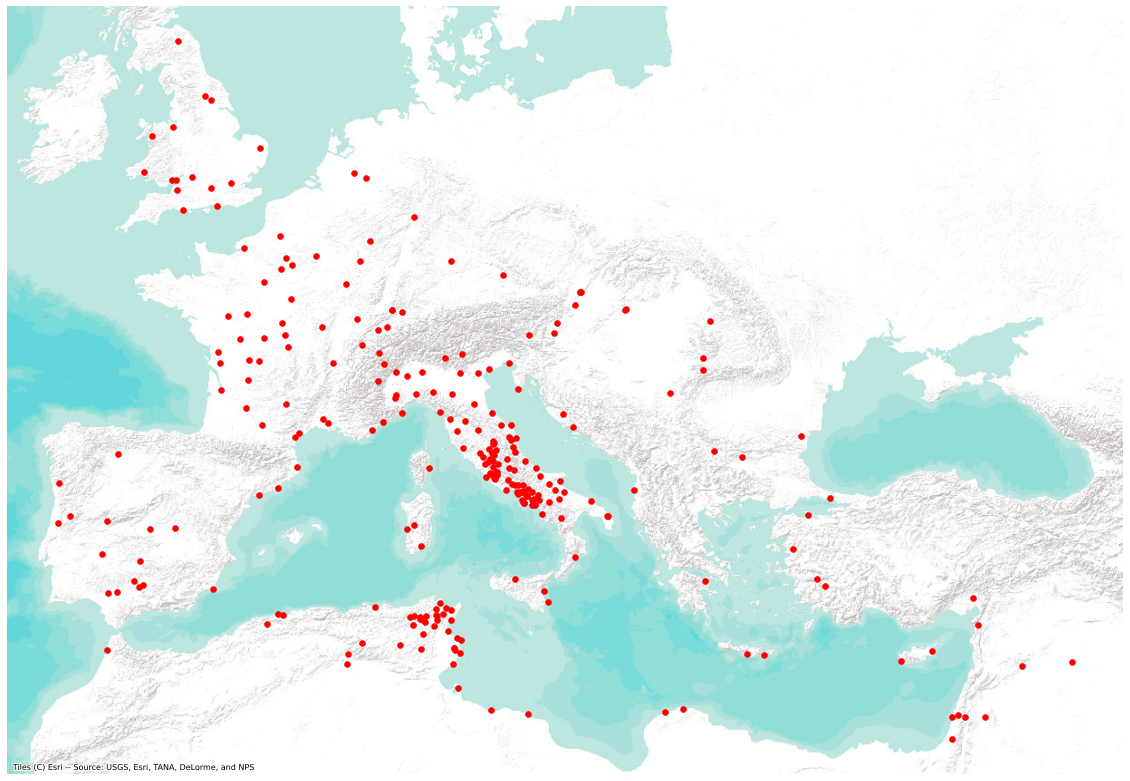

In [6]:
ramphs_gdf = gpd.read_file("roman-amphitheaters.geojson")

ramphs_gdf_epsg3857 = ramphs_gdf.to_crs(3857)

ax = ramphs_gdf_epsg3857.plot(figsize=(20, 20), color = 'red')
cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain)

ax.set_axis_off()
plt.savefig("all-roman-amphitheaters-map.png",pad_inches=0, bbox_inches='tight')

In [7]:
# interactive version
tb = ramphs_gdf_epsg3857.total_bounds

hv = ramphs_gdf_epsg3857.hvplot(global_extent=False,
                          
                           hover_cols = ['id'],
                           tiles='EsriTerrain',
                           xticks = 0, yticks = 0,
                           xlim = (tb[0]-300000,tb[2]),
                           ylim = (tb[1]-300000,tb[3]+300000),
                           height = 500,
                           width = 700,
                                c = 'red'
                           )


hv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (id)

In [8]:
# with roman territory using geopandas


url = "http://sebastianheath.com/roman-maps/roman_empire_ad_200_extent.geojson"
borders_gdf = gpd.read_file(url)

base = borders_gdf.plot(color = 'black', figsize = (40,24))
ramphs_gdf.plot(ax = base, color = 'red', markersize = 100)

plt.grid(False)
plt.axis('off')

plt.savefig('all-roman-amphitheaters-map-dark.png',pad_inches=0, bbox_inches='tight', transparent = True)
plt.close()

## Basic/Various Reporting

In [9]:
ramphs_df.head(2)

id                         title  label  latintoponym  \
0  duraEuroposAmphitheater  Amphitheater at Dura Europos   Dura  Dura Europus   
1        arlesAmphitheater         Amphitheater at Arles  Arles       Arelate   

                                  pleiades welchid golvinid  buildingtype  \
0  https://pleiades.stoa.org/places/893989              129  amphitheater   
1  https://pleiades.stoa.org/places/148217              154  amphitheater   

  chronogroup  secondcentury  ...  dimensionsunknown arenamajor arenaminor  \
0     severan          False  ...              False       31.0       25.0   
1     flavian           True  ...              False       47.0       32.0   

  extmajor  extminor  exteriorheight  longitude   latitude  elevation  \
0     50.0      44.0             NaN  40.728926  34.749855        223   
1    136.0     107.0             NaN   4.631111  43.677778         21   

   displaycolor  
0         green  
1         green  

[2 rows x 24 columns]

In [10]:
ramphs_df.describe()

capacity  arenamajor  arenaminor    extmajor    extminor  \
count    147.000000  179.000000  175.000000  216.000000  196.000000   
mean   12437.653061   56.838324   38.327314   95.953148   77.329898   
std     9256.039869   14.405574    8.648394   30.695044   25.440575   
min     1000.000000   25.000000   19.000000   25.000000   31.000000   
25%     5390.000000   46.900000   32.350000   74.000000   58.950000   
50%    10000.000000   58.000000   39.000000   92.900000   75.000000   
75%    17124.500000   66.000000   43.000000  114.250000   94.875000   
max    50000.000000  104.000000   74.000000  189.000000  156.000000   

       exteriorheight   longitude    latitude    elevation  
count        3.000000  270.000000  270.000000   270.000000  
mean        41.483333   10.583029   42.242567   196.440741  
std          9.859048    9.031733    4.923008   211.147903  
min         32.450000   -8.493330   31.608189  -121.000000  
25%         36.225000    5.498946   38.686097    34.250000  
50%         40.000000   10.954128   42.089044   121.000000  
75%         46.000000   14.156411   45.540916   287.250000  
max         52.000000   40.728926   55.602600  1170.000000

In [11]:
ramphs_df[ramphs_df.secondcentury].describe()

capacity  arenamajor  arenaminor    extmajor    extminor  \
count    137.000000  169.000000  165.000000  204.000000  186.000000   
mean   12220.693431   56.889408   38.465333   95.732255   77.303011   
std     9185.153364   14.534485    8.729698   29.665585   25.289675   
min     1200.000000   25.000000   19.000000   25.000000   31.000000   
25%     5380.000000   46.800000   32.700000   74.375000   59.100000   
50%     9700.000000   58.000000   39.000000   92.400000   75.000000   
75%    16000.000000   66.000000   43.000000  113.775000   94.375000   
max    50000.000000  104.000000   74.000000  189.000000  156.000000   

       exteriorheight   longitude    latitude    elevation  
count        2.000000  248.000000  248.000000   248.000000  
mean        42.225000   10.068252   42.353479   196.762097  
std         13.823938    8.823569    4.971936   211.346244  
min         32.450000   -8.493330   31.608189     1.000000  
25%         37.337500    4.237836   38.766624    34.750000  
50%         42.225000   10.606566   42.270997   123.500000  
75%         47.112500   14.049126   45.742034   285.750000  
max         52.000000   38.273763   55.602600  1170.000000

In [12]:
# Confirm that CSV is readable
# It would be nice if the "numeric pattern" string survived as strings.
pd.read_csv("roman-amphitheaters.csv", quoting = 2).describe()

welchid    golvinid      capacity  arenamajor  arenaminor  \
count  19.000000  162.000000    147.000000  179.000000  175.000000   
mean   10.105263  101.345679  12437.653061   56.838324   38.327314   
std     5.724166   57.975934   9256.039869   14.405574    8.648394   
min     1.000000    2.000000   1000.000000   25.000000   19.000000   
25%     5.500000   56.250000   5390.000000   46.900000   32.350000   
50%    10.000000  104.500000  10000.000000   58.000000   39.000000   
75%    15.500000  145.750000  17124.500000   66.000000   43.000000   
max    19.000000  298.000000  50000.000000  104.000000   74.000000   

         extmajor    extminor  exteriorheight   longitude    latitude  \
count  216.000000  196.000000        3.000000  270.000000  270.000000   
mean    95.953148   77.329898       41.483333   10.583029   42.242567   
std     30.695044   25.440575        9.859048    9.031733    4.923008   
min     25.000000   31.000000       32.450000   -8.493330   31.608189   
25%     74.000000   58.950000       36.225000    5.498946   38.686097   
50%     92.900000   75.000000       40.000000   10.954128   42.089044   
75%    114.250000   94.875000       46.000000   14.156411   45.540916   
max    189.000000  156.000000       52.000000   40.728926   55.602600   

         elevation  
count   270.000000  
mean    196.440741  
std     211.147903  
min    -121.000000  
25%      34.250000  
50%     121.000000  
75%     287.250000  
max    1170.000000

In [13]:
# which have heights
ramphs_df[ramphs_df.exteriorheight > 0]

id                         title           label  \
4   romeFlavianAmphitheater  Flavian Amphitheater at Rome       Colosseum   
91     thysdrusAmphitheater      Amphitheater at Thysdrus  Thysdrus (lg.)   
98         pulaAmphitheater          Amphitheater at Pula            Pula   

                                      latintoponym  \
4                                                    
91                                                   
98  Colonia Pietas Iulia Pola Pollentia Herculanea   

                                   pleiades welchid golvinid  buildingtype  \
4   https://pleiades.stoa.org/places/423025              152  amphitheater   
91  https://pleiades.stoa.org/places/324835              186  amphitheater   
98  https://pleiades.stoa.org/places/197448              151  amphitheater   

       chronogroup  secondcentury  ...  dimensionsunknown arenamajor  \
4          flavian           True  ...              False      83.00   
91    post-severan          False  ...              False      65.00   
98  julio-claudian           True  ...              False      67.95   

   arenaminor extmajor  extminor  exteriorheight  longitude   latitude  \
4       48.00   189.00     156.0           52.00  12.492269  41.890169   
91      39.00   148.00     122.0           40.00  10.706939  35.296390   
98      41.65   132.45     105.1           32.45  13.850243  44.873229   

    elevation  displaycolor  
4          22         green  
91        111         green  
98         16         green  

[3 rows x 24 columns]

In [14]:
# which don't have exteriormajor
ramphs_df[pd.isnull(ramphs_df.extmajor)].sort_values(by = 'longitude')\
[['id','modcountry','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

id      modcountry  \
158                        bragaAmphitheater        Portugal   
167                     bobadelaAmphitheater        Portugal   
56                         lixusAmphitheater         Morocco   
122                      caparraAmphitheater           Spain   
195                       espejoAmphitheater           Spain   
159                       sisapoAmphitheater           Spain   
268                       toledoAmphitheater           Spain   
88                   cirencesterAmphitheater  United Kingdom   
69                    aldburoughAmphitheater  United Kingdom   
256                         yorkAmphitheater  United Kingdom   
46                        gennesAmphitheater          France   
144                         agenAmphitheater          France   
183                    chassenonAmphitheater          France   
151              caistorStEdmundAmphitheater  United Kingdom   
148                     chartresAmphitheater          France   
37                         parisAmphitheater          France   
204           montbouyGalloRomanAmphitheater          France   
147                        meauxAmphitheater          France   
207                  mesarafeltaAmphitheater         Algeria   
20                      nijmegenAmphitheater     Netherlands   
63   hydataHypsitanaForumTraianiAmphitheater           Italy   
193                     tebourbaAmphitheater         Tunisia   
209                       carpisAmphitheater         Tunisia   
200                       pupputAmphitheater         Tunisia   
260                 reggioEmiliaAmphitheater           Italy   
264                       trentoAmphitheater           Italy   
205              statiliusTaurusAmphitheater           Italy   
3                           ludusMagnusArena           Italy   
227                   forumNovumAmphitheater           Italy   
84                        assisiAmphitheater           Italy   
136                   monteleoneAmphitheater           Italy   
235                        fermoAmphitheater           Italy   
253                 suessaAruncaAmphitheater           Italy   
154                      liternoAmphitheater           Italy   
242                        teanoAmphitheater           Italy   
13                 pozzuoliEarlyAmphitheater           Italy   
241                       chietiAmphitheater           Italy   
140                    beneventoAmphitheater           Italy   
254                   altripaldaAmphitheater           Italy   
255                       compsaAmphitheater           Italy   
173                    gleisdorfAmphitheater         Austria   
240                      sipontoAmphitheater           Italy   
22                            carnuntumLudus         Austria   
238                      egnaziaAmphitheater           Italy   
39                        cyreneAmphitheater           Libya   
119                       sophiaAmphitheater        Bulgaria   
206                      hisaryaAmphitheater        Bulgaria   
263                      nazilliAmphitheater          Turkey   
223                        geyreAmphitheater          Turkey   
258                     istanbulAmphitheater          Turkey   
106                      salamisAmphitheater          Cyprus   
47               scythopolisNysaAmphitheater          Israel   
103                      antiochAmphitheater          Turkey   
176                      palmyraAmphitheater           Syria   

                     latintoponym golvinid  extmajor  arenamajor   latitude  \
158               Bracara Augusta                NaN         NaN  41.546669   
167                     Elbocoris                NaN        50.0  40.361088   
56                          Lixus                NaN        34.0  35.199900   
122  Municipium Flavium Caparense                NaN        30.0  40.164159   
195                         Ucubi       11       NaN        35.0  37.683989   
159                                            

In [15]:
ramphs_df[ramphs_df.golvinid == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

id          latintoponym golvinid  extmajor  \
2              lyonAmphitheater              Lugdunum              105.0   
3              ludusMagnusArena          Ludus Magnus                NaN   
6    eleutheropolisAmphitheater        Eleutheropolis               71.0   
9          newsteadAmphitheater            Trimontium               70.0   
11            cumaeAmphitheater                 Cumae              114.0   
..                          ...                   ...      ...       ...   
262  torreparedonesAmphitheater  Colonia Virtus Iulia               69.0   
263         nazilliAmphitheater              Mastaura                NaN   
264          trentoAmphitheater             Tridentum                NaN   
268          toledoAmphitheater               Toletum                NaN   
269    kaiseraugustAmphitheater    Castrum Rauracense               50.0   

     arenamajor   latitude  longitude  
2          67.6  45.770556   4.830556  
3           NaN  41.889950  12.494913  
6          47.0  31.608189  34.893845  
9          37.0  55.602600  -2.691900  
11          NaN  40.841847  14.056000  
..          ...        ...        ...  
262         NaN  37.752468  -4.380600  
263         NaN  37.955596  28.338099  
264        62.0  46.069205  11.125334  
268         NaN  39.865349  -4.022888  
269         NaN  47.540822   7.721596  

[108 rows x 7 columns]

In [16]:
ramphs_df[ramphs_df.latintoponym == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

id latintoponym golvinid  \
4                        romeFlavianAmphitheater                   152   
5                     romeAmphitheatrumCastrense                   189   
19                        porolissumAmphitheater                    39   
28                           italicaAmphitheater                   168   
34                        viminaciumAmphitheater                         
35                       flaviaSolvaAmphitheater                    52   
38   octodurusForumClaudiiVallensiumAmphitheater                    27   
44                      charterhouseAmphitheater                         
47                   scythopolisNysaAmphitheater                         
52                           virunumAmphitheater                    51   
61                           allifaeAmphitheater                         
63       hydataHypsitanaForumTraianiAmphitheater                         
77                            salonaAmphitheater                   181   
79                             tiburAmphitheater                         
86                         lambaesisAmphitheater                   111   
87                          mactarisAmphitheater                   119   
89                        vindonissaAmphitheater                    17   
90                     thysdrusSmallAmphitheater                   112   
91                          thysdrusAmphitheater                   186   
93                            gortynAmphitheater                         
94                        leptiminusAmphitheater                   114   
95                             miciaAmphitheater                    47   
96                          gemellaeAmphitheater                    44   
97                         cherchellAmphitheater                    81   
100                         caesareaAmphitheater                         
102                        anazarbusAmphitheater                         
103                          antiochAmphitheater                         
104                          cyzicusAmphitheater                         
105                         sabrathaAmphitheater                   120   
106                          salamisAmphitheater                         
107                           paphosAmphitheater                         
110                      tomen-y-murAmphitheater                    31   
111                          thaenaeAmphitheater                    71   
117                          bararusAmphitheater                   187   
118                     castraAlbanaAmphitheater                   190   
120                        ptolemaisAmphitheater                    76   
159                           sisapoAmphitheater                         
163                         arnsburgAmphitheater                         
164                        ierapetraAmphitheater                         
171                          dambachAmphitheater                         
173                        gleisdorfAmphitheater                         
176                          palmyraAmphitheater                         
189                   genzanoPrivateAmphitheater                         
204               montbouyGalloRomanAmphitheater                         
205                  statiliusTaurusAmphitheater                         
225                                zagaroloLudus                         
226                         tusculumAmphitheater                   184   
233                      jebelMorabaAmphitheater                         
267               saintGeorgesDuBoisAmphitheater                   103   

     extmajor  arenamajor   latitude  longitude  
4       189.0       83.00  41.890169  12.492269  
5        88.0         NaN  41.887715  12.515144  
19       84.0       64.00  47.177552  23.154052  
28      160.0       70.00  37.443893  -6.046742  
34       84.0       55.00  44.737985  21.220083  
35       97.0       85.00  46.767153  15.5657

## Duplicate Checking

In [17]:
dups = ramphs_df[ramphs_df.label.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [18]:
dups = ramphs_df[ramphs_df.id.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [19]:
dups = ramphs_df[ramphs_df.pleiades.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 15

False

In [20]:
dups = ramphs_df[ramphs_df.latintoponym.duplicated(keep = False)]\
[['id','pleiades','latintoponym',
  'latitude','longitude']].sort_values('pleiades')

len(dups.query("latintoponym != ''")) == 11

True

# Chronogrps

In [21]:
c_grps_from_j = j['romanamphitheaterschronogroups']

In [22]:
c_grps_to_csv = [[g['id'],g['startdate'],g['enddate']] for g in c_grps_from_j]

In [23]:
print(f"In c_grps, not in data: {set([i[0] for i in c_grps_to_csv]) - set([i[8] for i in d])}")
print(f"In data, not in c_grps: {set([i[8] for i in d]) - set([i[0] for i in c_grps_to_csv])}")

In c_grps, not in data: set()
In data, not in c_grps: set()


In [24]:
if (set([i[0] for i in c_grps_to_csv]) == set([i[8] for i in d])):
    c_grps_df = pd.DataFrame(c_grps_to_csv, columns = ('id','startdate','enddate'))
    c_grps_df.to_csv("chronogrps.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [25]:
# Provinces (new, incomplete)

# Golvin ID

In [26]:
L = ramphs_df[ramphs_df['golvinid'] != '']['golvinid'].astype(int).sort_values().tolist()
missingItems = [x for x in list(range(300)) if not x in L]
missingItems

[0,
 1,
 18,
 25,
 28,
 29,
 30,
 32,
 35,
 36,
 37,
 40,
 43,
 48,
 49,
 50,
 60,
 63,
 68,
 85,
 89,
 94,
 95,
 96,
 134,
 150,
 169,
 171,
 173,
 175,
 176,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 299]

In [27]:
ramphs_df[ramphs_df['golvinid'] == '27']

id  \
38  octodurusForumClaudiiVallensiumAmphitheater   

                                                title      label latintoponym  \
38  Amphitheater at Octodurus/Forum Claudii Vallen...  Octodorus                

                                   pleiades welchid golvinid  buildingtype  \
38  https://pleiades.stoa.org/places/167859               27  amphitheater   

   chronogroup  secondcentury  ...  dimensionsunknown arenamajor arenaminor  \
38    imperial           True  ...              False       74.0       62.0   

   extmajor  extminor  exteriorheight  longitude   latitude  elevation  \
38    118.0     106.0             NaN   7.073493  46.094356        480   

    displaycolor  
38         green  

[1 rows x 24 columns]

In [28]:
# 4 DIMS, No cap

In [34]:
ramphs_df.loc[ramphs_df[['extmajor','extminor','arenamajor','arenaminor']].notnull().all(1) & ramphs_df['capacity'].isnull(),['id','golvinid','capacity']].hvplot.table()

:Table   [id,golvinid,capacity]